In [1]:
# optimize_bracket.py

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import optuna

# Load CSV
df = pd.read_csv('../bracket_outputs/brackets.csv')

# Features and target
features = ['flangeX', 'flangeY', 'thickness', 'holeRadius', 'holeOffset']
target = 'mass'

X = df[features]
y = df[target]

# Train-test split (for surrogate evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train surrogate model (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"\n🎯 Surrogate Model MAE: {mae:.2f}")

# Define objective function for Optuna
def objective(trial):
    # Sample parameters
    flangeX = trial.suggest_float('flangeX', 50.0, 80.0)
    flangeY = trial.suggest_float('flangeY', 60.0, 100.0)
    thickness = trial.suggest_float('thickness', 5.0, 15.0)
    holeRadius = trial.suggest_float('holeRadius', 2.0, 5.0)
    holeOffset = trial.suggest_float('holeOffset', 8.0, 20.0)

    # You can enforce geometric constraints here
    if holeOffset > min(flangeX, flangeY) / 2:
        return float("inf")  # Invalid design

    # Predict mass using surrogate model
    input_vec = [[flangeX, flangeY, thickness, holeRadius, holeOffset]]
    predicted_mass = model.predict(input_vec)[0]

    return predicted_mass

# Create Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Results
print("\n🏆 Best design parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value:.2f}")
print(f"📉 Predicted mass: {study.best_value:.2f}")

# Optionally: save best candidates to CSV
results_df = study.trials_dataframe()
results_df.to_csv('optimized_brackets.csv', index=False)
print("\n📁 Saved top designs to optimized_brackets.csv")


/Users/ksnaik/miniconda3/envs/practice/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-18 00:43:37,707] A new study created in memory with name: no-name-cff2ab5e-c77c-48b7-a3a9-f51fc5f6920f
/Users/ksnaik/miniconda3/envs/practice/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[I 2025-05-18 00:43:37,712] Trial 0 finished with value: 78759.2 and parameters: {'flangeX': 70.71923701043802, 'flangeY': 90.9285643542382, 'thickness': 12.643658808576188, 'holeRadius': 2.663352914457282, 'holeOffset': 10.911899909175725}. Best is trial 0 with value: 78759.2.
/Users/ksnaik/miniconda3/envs/practice/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarnin


🎯 Surrogate Model MAE: 1558.27


/Users/ksnaik/miniconda3/envs/practice/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[I 2025-05-18 00:43:37,916] Trial 28 finished with value: 37450.4 and parameters: {'flangeX': 53.544746835331786, 'flangeY': 63.824610490881625, 'thickness': 8.039022057671389, 'holeRadius': 4.327448651037984, 'holeOffset': 18.542419874529482}. Best is trial 12 with value: 37450.4.
/Users/ksnaik/miniconda3/envs/practice/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[I 2025-05-18 00:43:37,926] Trial 29 finished with value: 55889.6 and parameters: {'flangeX': 58.795148080616144, 'flangeY': 82.6488368637692, 'thickness': 12.36014388390225, 'holeRadius': 4.979228247228241, 'holeOffset': 17.738781308373404}. Best is trial 12 with valu


🏆 Best design parameters:
  flangeX: 50.29
  flangeY: 60.01
  thickness: 8.74
  holeRadius: 4.92
  holeOffset: 19.89
📉 Predicted mass: 37450.40

📁 Saved top designs to optimized_brackets.csv


/var/folders/08/ryxz27sd74z0kyphfhd61vz00000gn/T/ipykernel_72694/3584108.py:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


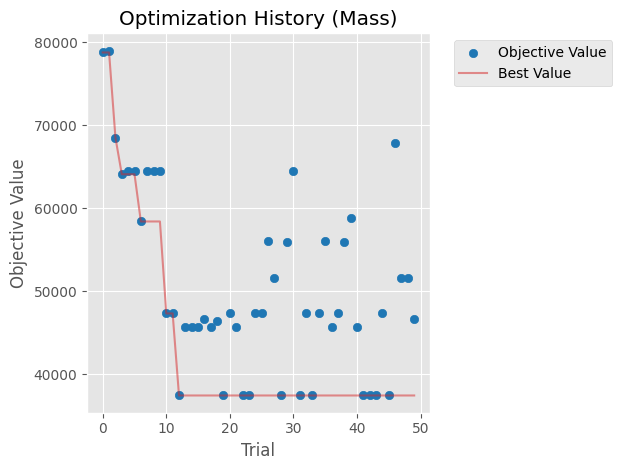

/var/folders/08/ryxz27sd74z0kyphfhd61vz00000gn/T/ipykernel_72694/3584108.py:11: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


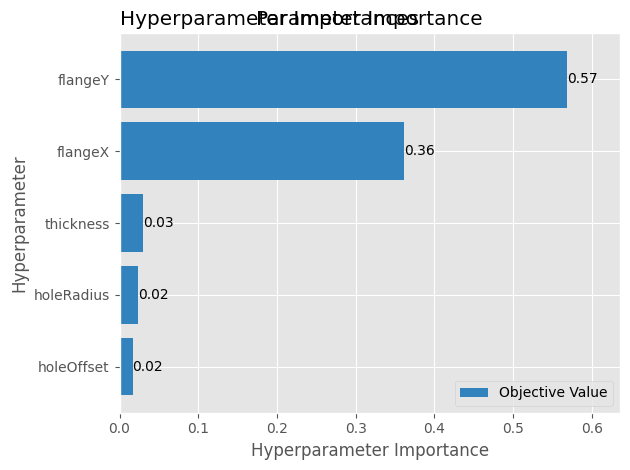

In [2]:
import matplotlib.pyplot as plt

# Plot loss vs trial
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History (Mass)")
plt.tight_layout()
plt.savefig("optuna_history.png")
plt.show()

# Plot parameter importance (optional)
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Parameter Importance")
plt.tight_layout()
plt.savefig("optuna_importance.png")
plt.show()
